In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim 
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1)

In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
file_dir = "/content/drive/MyDrive/training/"
dataset = ImageFolder(file_dir, tt.Compose([tt.Resize((224, 224)), tt.ToTensor()]))
print(len(dataset))

4986


In [4]:
from torch.utils.data.dataloader import DataLoader
dataset_DL = DataLoader(dataset, batch_size = 128, shuffle = True,  num_workers = 2, pin_memory = True) 

In [ ]:
print(len(dataset_DL))

56


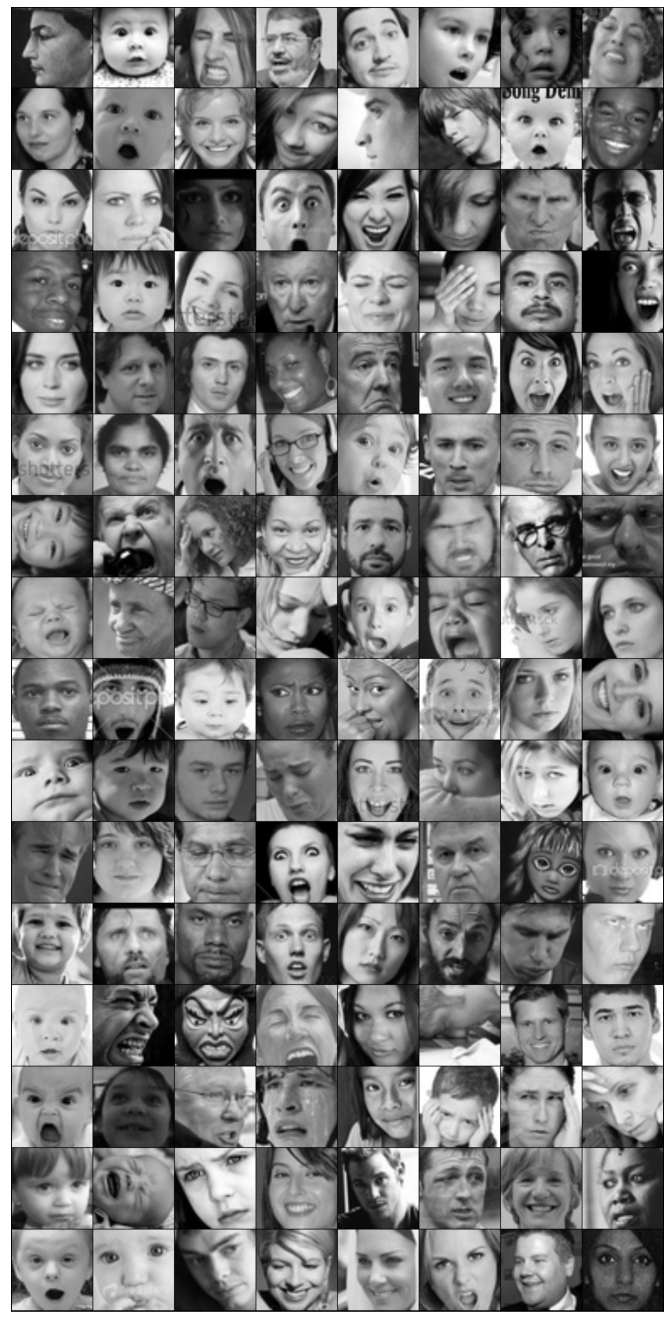

In [ ]:
from torchvision.utils import make_grid

def show_batch(DL):
  for img, label in DL:
    fig, ax = plt.subplots(figsize = (24, 24))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img, nrows = 10).permute(1,2,0))
    break
show_batch(dataset_DL)

In [5]:
classes = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [ ]:
dataset[0][0].size()

torch.Size([3, 224, 224])

In [ ]:
train = "/content/drive/MyDrive/training"
val = "/content/drive/MyDrive/validation"

transform = tt.Compose([tt.Resize((64,64)), 
                                tt.ToTensor()])

# Load data from Google Drive
train_data = torchvision.datasets.ImageFolder(train, transform=transform)
val_data = torchvision.datasets.ImageFolder(val, transform=transform)

print("The number of images in each set: ")
print("training set size: ", len(train_data))
print("validation set size: ", len(val_data)) 

The number of images in each set: 
training set size:  7067
validation set size:  996


In [6]:
test = "/content/drive/MyDrive/APS360 Test Set"

transform = tt.Compose([tt.Resize((64,64)), tt.Grayscale(3),
                                tt.ToTensor()])

test_data = torchvision.datasets.ImageFolder(test, transform=transform)

print("Test set size: ", len(test_data))

Test set size:  263


In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128 ##PARAMETER
train_DL = DataLoader(train_data, batch_size, shuffle = True,  num_workers = 2, pin_memory = True) 
val_DL = DataLoader(val_data, batch_size*2, num_workers = 2, pin_memory = True)

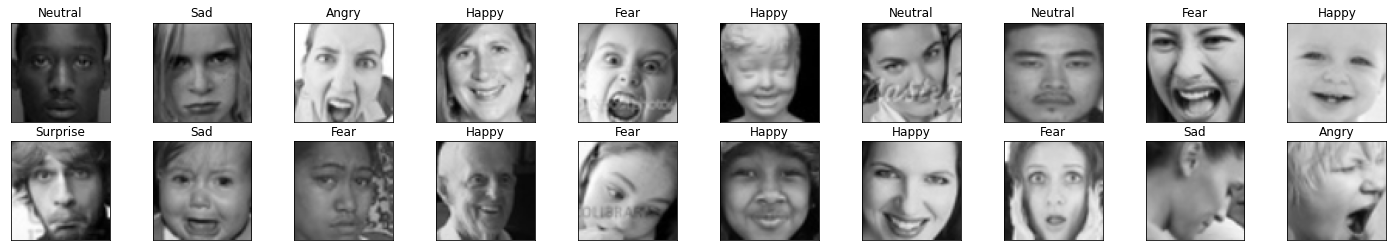

In [ ]:
dataiter = iter(train_DL)
images, labels = dataiter.next()
images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [7]:
class CNN_model(nn.Module):
  def __init__(self):
    super(CNN_model, self).__init__()
    self.name = "CNN_model"
    self.conv1 = nn.Conv2d(3, 5, 3) #62,62,5
    self.norm1 = nn.BatchNorm2d(5)
    self.conv1_1 = nn.Conv2d(5, 10, 3) #60,60,10
    self.norm1_1 = nn.BatchNorm2d(10)
    self.pool1 = nn.MaxPool2d(2, 2) #30,30,10
    self.conv2 = nn.Conv2d(10, 15, 3) #28,28,15
    self.norm2 = nn.BatchNorm2d(15)
    self.conv2_2 = nn.Conv2d(15, 20, 3) #26,26,20
    self.norm2_2 = nn.BatchNorm2d(20)
    self.pool2 = nn.MaxPool2d(2, 2) #13,13,20
    self.fc1 = nn.Linear(13*13*20, 640) 
    self.fc2 = nn.Linear (640, 8)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, img):
        img = F.relu(self.norm1(self.conv1(img)))
        img = self.pool1(F.relu(self.norm1_1(self.conv1_1(img))))
        #print('img_shape:',img.shape)
        img = F.relu(self.norm2(self.conv2(img)))
        img = self.pool2(F.relu(self.norm2_2(self.conv2_2(img))))
        #print('img_shape:',img.shape)
        img = img.view(-1, 20*13*13)
        img = self.dropout(img)
        img = F.relu(self.fc1(img))
        img = self.fc2(img)
        img = F.softmax(img, dim=1)
        return img

In [ ]:
model = CNN_model()

In [8]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    for imgs, labels in data:

       #####
       ########################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
   
        output = model(imgs) 
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total
  
print ('done')

done


In [ ]:
def train(model, train_data,  batch_size=64, learning_rate=0.001, num_epochs=1):
   
    train_loader = DataLoader(train_data, batch_size, shuffle = True,  num_workers = 2, pin_memory = True)
    valid_loader = DataLoader(val_data, batch_size, num_workers = 2, pin_memory = True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    epoch = 0 # the number of iterations
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):

            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
              
            out = model(imgs)             # forward pass
            
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch


        # save the current training information
        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
        print("Epoch number: ", epoch+1)
        print("Training Accuracy: ",train_acc[epoch])
        print("Validation Accuracy: ",val_acc[epoch])
        print("Loss from previous epoch: ", losses[epoch-1], "\n")
 
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
train_data.class_to_idx

{'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprise': 5}

CUDA is available!  Training on GPU ...
Epoch number:  1
Training Accuracy:  0.3319654733267299
Validation Accuracy:  0.23493975903614459
Loss from previous epoch:  0.056196171790361404 

Epoch number:  2
Training Accuracy:  0.35644545068628836
Validation Accuracy:  0.26907630522088355
Loss from previous epoch:  0.056196171790361404 

Epoch number:  3
Training Accuracy:  0.38686854393660675
Validation Accuracy:  0.27309236947791166
Loss from previous epoch:  0.061069559305906296 

Epoch number:  4
Training Accuracy:  0.4082354605914815
Validation Accuracy:  0.29417670682730923
Loss from previous epoch:  0.05860064923763275 

Epoch number:  5
Training Accuracy:  0.41715013442762133
Validation Accuracy:  0.31224899598393574
Loss from previous epoch:  0.055357951670885086 

Epoch number:  6
Training Accuracy:  0.42380076411490025
Validation Accuracy:  0.32028112449799195
Loss from previous epoch:  0.06007842347025871 

Epoch number:  7
Training Accuracy:  0.45450686288382625
Validation Ac

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f259ae03560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f259ae03560>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch number:  12
Training Accuracy:  0.5003537568982596
Validation Accuracy:  0.3534136546184739
Loss from previous epoch:  0.0556134469807148 

Epoch number:  13
Training Accuracy:  0.49893872930522143
Validation Accuracy:  0.3493975903614458
Loss from previous epoch:  0.05658162012696266 

Epoch number:  14
Training Accuracy:  0.5113909721239565
Validation Accuracy:  0.357429718875502
Loss from previous epoch:  0.05918622016906738 

Epoch number:  15
Training Accuracy:  0.5163435686995896
Validation Accuracy:  0.3463855421686747
Loss from previous epoch:  0.057106975466012955 

Epoch number:  16
Training Accuracy:  0.5195981321635772
Validation Accuracy:  0.3413654618473896
Loss from previous epoch:  0.05782051756978035 

Epoch number:  17
Training Accuracy:  0.5510117447290223
Validation Accuracy:  0.3815261044176707
Loss from previous epoch:  0.05506809428334236 

Epoch number:  18
Training Accuracy:  0.5481816895429461
Validation Accuracy:  0.36646586345381527
Loss from previous 

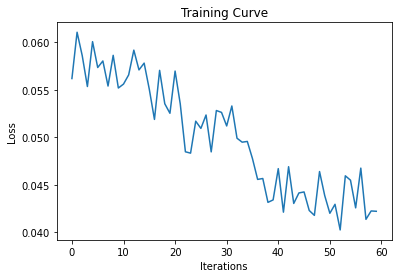

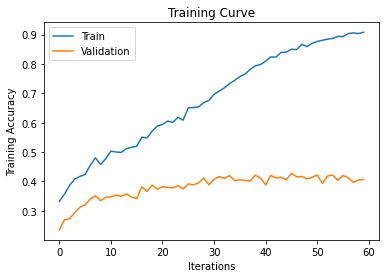

Final Training Accuracy: 0.9081647092118297
Final Validation Accuracy: 0.4066265060240964


In [ ]:
use_cuda = True
model = CNN_model()

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

train(model, train_data, batch_size = 32, learning_rate = 0.01, num_epochs=60)

In [9]:
def get_accuracy_test(model, data, emotion):
    correct = 0
    total = 0
    for imgs, labels in data:

       #####
       ########################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        if labels[0].item() is emotion:
          output = model(imgs) 
          pred = output.max(1, keepdim=True)[1]
          correct += pred.eq(labels.view_as(pred)).sum().item()
          total += imgs.shape[0]
    if total is not 0:
      return correct / total
    else:
      return 1

In [10]:
def get_wrong_test(model, data, emotion):
    correct = 0
    total = 0
    predictions = [0]*6
    for imgs, labels in data:

       #####
       ########################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
        if labels[0].item() is emotion:
          output = model(imgs) 
          pred = output.max(1, keepdim=True)[1]
          predictions[pred[0].item()] += 1
          correct += pred.eq(labels.view_as(pred)).sum().item()
          total += imgs.shape[0]
    for x in range(0,6):
      predictions[x] = round(predictions[x] / total *100, 2)
    return predictions

In [ ]:
drive.mount('/content/drive', force_remount=True)
test = "/content/drive/MyDrive/Praniti_Emotions"

transform = tt.Compose([tt.Resize((64,64)), tt.Grayscale(3),
                                tt.ToTensor()])

test_data_new = torchvision.datasets.ImageFolder(test, transform=transform)

print("Test set size: ", len(test_data_new))

Mounted at /content/drive
Test set size:  6


In [ ]:
use_cuda = False
model = CNN_model()
state = torch.load("/content/model_CNN_model_bs32_lr0.01_epoch50", 
                   map_location=torch.device('cpu'))
model.load_state_dict(state)
test_DL = DataLoader(test_data_new, 1, shuffle = True,  num_workers = 2, 
                     pin_memory = True)
#print(get_accuracy(model, test_DL))
print('Accuracy')
print('Angry:', get_accuracy_test(model, test_DL, 0)) #angry
print('Fear:',get_accuracy_test(model, test_DL, 1)) #fear
print('Happy:',get_accuracy_test(model, test_DL, 2)) #happy
print('Neutral:',get_accuracy_test(model, test_DL, 3)) #neutral
print('Sad:',get_accuracy_test(model, test_DL, 4)) #sad
print('Surprised:',get_accuracy_test(model, test_DL, 5)) #surprised

Accuracy
Angry: 0.0
Fear: 0.0
Happy: 1.0
Neutral: 0.0
Sad: 1.0
Surprised: 1.0


In [13]:
use_cuda = False
model = CNN_model()
state = torch.load("/content/model_CNN_model_bs32_lr0.01_epoch50", map_location=torch.device('cpu'))
model.load_state_dict(state)
test_DL = DataLoader(test_data, 1, shuffle = True,  num_workers = 2, pin_memory = True)
print("     Angry Fear Happy Neutral Sad Surprise ")
print("Angry " + str(get_wrong_test(model, test_DL, 0))) #angry
print("Fear " + str(get_wrong_test(model, test_DL, 1))) #fear
print("Happy " + str(get_wrong_test(model, test_DL, 2))) #happy
print("Neutral " + str(get_wrong_test(model, test_DL, 3))) #neutral
print("Sad " + str(get_wrong_test(model, test_DL, 4))) #sad
print("Surprise " + str(get_wrong_test(model, test_DL, 5))) #surprised

     Angry Fear Happy Neutral Sad Surprise 
Angry [34.88, 0.0, 9.3, 30.23, 23.26, 2.33]
Fear [14.29, 19.05, 7.14, 40.48, 9.52, 9.52]
Happy [8.7, 2.17, 71.74, 6.52, 6.52, 4.35]
Neutral [11.11, 6.67, 11.11, 62.22, 4.44, 4.44]
Sad [13.64, 4.55, 6.82, 59.09, 15.91, 0.0]
Surprise [13.95, 9.3, 13.95, 13.95, 4.65, 44.19]


In [ ]:
use_cuda = False
model = CNN_model()
state = torch.load("/content/model_CNN_model_bs32_lr0.01_epoch50", map_location=torch.device('cpu'))
model.load_state_dict(state)
test_DL = DataLoader(test_data_new, 1, shuffle = True,  num_workers = 2, pin_memory = True)
#print(get_accuracy(model, test_DL))
print('Accuracy')
print('Angry:', get_accuracy_test(model, test_DL, 0)) #angry
print('Fear:',get_accuracy_test(model, test_DL, 1)) #fear
print('Happy:',get_accuracy_test(model, test_DL, 2)) #happy
print('Neutral:',get_accuracy_test(model, test_DL, 3)) #neutral
print('Sad:',get_accuracy_test(model, test_DL, 4)) #sad
print('Surprised:',get_accuracy_test(model, test_DL, 5)) #surprised

Accuracy
Angry: 0.0
Fear: 0.0
Happy: 1.0
Neutral: 0.0
Sad: 0.0
Surprised: 0.0


In [ ]:
test_angry = torch.utils.data.Subset(test_data, range(20,1000))

test_angry_DL = DataLoader(test_angry, 32, shuffle = True,  num_workers = 2, pin_memory = True)

#print(get_accuracy_test(model, test_angry_DL))

In [ ]:
inputs, classes = next(iter(train_DL))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

inputs = inputs.to(device)
 
model = model.to(device)
inputs=inputs.to(device)
 
outputs=model(inputs)
_, preds = torch.max(outputs, 1)
preds=preds.cpu().numpy()
classes=classes.numpy()
print(preds)
print(classes)